In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# Adding a Connection
conn = engine.connect()

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [15]:
# Obtaining columns within the Measurement table
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
# Viewing a sample of the data in the Measurement table
pd.read_sql("SELECT * FROM Measurement", conn).head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [17]:
# Obtaining columns within the Station table
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Viewing a sample of the data in the Station table
pd.read_sql("SELECT * FROM Station", conn).head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Obtaining the last data point in the database
last_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_data

('2017-08-23')

In [20]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [21]:
# Perform a query to retrieve the date and precipitation scores
data_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).order_by(Measurement.date).all()
# Printing 10 first elements from the list 
print(data_precipitation[:10])

[('2016-08-23', 0.0), ('2016-08-23', 0.15), ('2016-08-23', 0.05), ('2016-08-23', None), ('2016-08-23', 0.02), ('2016-08-23', 1.79), ('2016-08-23', 0.7), ('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28)]


In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
data_precipitation_df = pd.DataFrame(data_precipitation)
data_precipitation_df.set_index('date', inplace=True,)
data_precipitation_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


In [23]:
# Sort the dataframe by date
# I am assuming this needs to be sorted in Ascending order
data_precipitation_df.sort_index(ascending = True)
data_precipitation_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


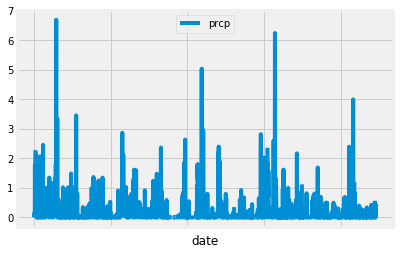

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data
data_precipitation_df.plot()
plt.legend(loc="upper center")
plt.show()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
# station_count = session.query(func.count(Station.id)).all()
station_count=session.query(Station).count()
station_count

9

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# From the previous query, we know that the most active station is USC00519281. Therefore we will add a filter
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# We already know that USC00519281 has the highest number of temperature observations. 

# 1. Obtaining the last data point in the database
session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()

('2017-08-18')

In [30]:
# 2. Calculate the date 1 year ago from the last data point in the database for USC00519281
query_date_station = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print("Query Date: ", query_date_station)

Query Date:  2016-08-18


In [31]:
# 3. Perform a query to retrieve the date and precipitation scores
data_precipitation_station = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date_station).filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()
# Printing 10 first elements from the list 
print(data_precipitation_station[:10])

[('2016-08-18', 80.0), ('2016-08-19', 79.0), ('2016-08-20', 81.0), ('2016-08-21', 79.0), ('2016-08-22', 78.0), ('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0)]


In [32]:
# 4. Save the query results as a Pandas DataFrame and set the index to the date column
data_precipitation_station_df = pd.DataFrame(data_precipitation_station)
data_precipitation_station_df.set_index('date', inplace=True,)
data_precipitation_station_df.head(10)

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0


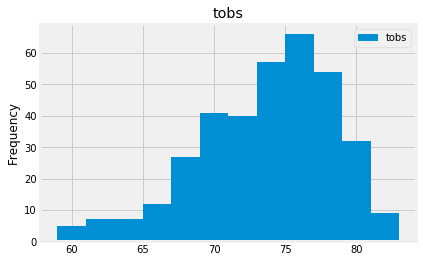

In [33]:
# Plot the results as a histogram
# data_precipitation_station_df['tobs'].hist()

data_precipitation_station_df.hist(column= 'tobs', bins=12, grid=True, label="tobs")

plt.ylabel('Frequency')
plt.legend(loc="best")
plt.show()

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [48]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# I will assume a start date of 2016-09-23 to 2016-09-30
print(calc_temps('2016-09-23', '2016-09-30'))

[(73.0, 78.54716981132076, 83.0)]


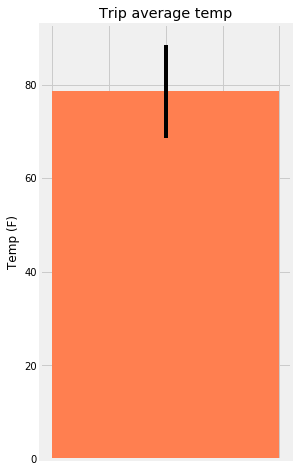

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


tmax = calc_temps('2016-09-23', '2016-09-30')[0][2]
tavg = calc_temps('2016-09-23', '2016-09-30')[0][1]
tmin = calc_temps('2016-09-23', '2016-09-30')[0][0]

yerr = tmax - tmin

plt.figure(figsize=(4, 8))
plt.tick_params(bottom='off', top='off', labelbottom='off')
plt.bar(tmax, tavg, yerr = yerr, color = 'coral')
plt.ylabel('Temp (F)')
plt.title('Trip average temp')
# plt.grid()
plt.show()

In [51]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_trip_yearago = dt.date(2016, 9, 23) - dt.timedelta(days=365)
# start_trip_yearago
end_trip_yearago = dt.date(2016, 9, 30) - dt.timedelta(days=365)

session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= start_trip_yearago).filter(Measurement.date <= end_trip_yearago).\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

# Codes For Flask

In [52]:
# Precipitation Dictionary. For Loop using data_precipitation List
prcp_dict = {date:prcp for date, prcp in data_precipitation}
print(prcp_dict)

{'2016-08-23': 0.7, '2016-08-24': 1.45, '2016-08-25': 0.11, '2016-08-26': 0.01, '2016-08-27': None, '2016-08-28': 2.07, '2016-08-29': 0.9, '2016-08-30': 0.05, '2016-08-31': 2.46, '2016-09-01': 0.01, '2016-09-02': 0.03, '2016-09-03': 1.0, '2016-09-04': 0.44, '2016-09-05': 0.18, '2016-09-06': 1.0, '2016-09-07': 1.35, '2016-09-08': 0.15, '2016-09-09': 0.35, '2016-09-10': 1.16, '2016-09-11': 0.6, '2016-09-12': 1.04, '2016-09-13': 1.2, '2016-09-14': 6.7, '2016-09-15': 3.35, '2016-09-16': 0.61, '2016-09-17': 0.23, '2016-09-18': 0.42, '2016-09-19': 0.25, '2016-09-20': 0.43, '2016-09-21': 1.02, '2016-09-22': 0.75, '2016-09-23': 0.33, '2016-09-24': 0.27, '2016-09-25': 0.04, '2016-09-26': 1.02, '2016-09-27': 1.0, '2016-09-28': 0.05, '2016-09-29': 1.49, '2016-09-30': 0.38, '2016-10-01': 1.02, '2016-10-02': 0.61, '2016-10-03': 0.46, '2016-10-04': 3.46, '2016-10-05': 0.81, '2016-10-06': 0.04, '2016-10-07': 0.01, '2016-10-08': 0.04, '2016-10-09': 0.0, '2016-10-10': 0.0, '2016-10-11': 0.35, '2016-10-

In [55]:
# Data for Stations
results = session.query(Station.station).all()
# To obtain a list of station from a list of tuples
station = list(np.ravel(results))
station

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [56]:
# Pulling dates and temperatures
query_date_temps = dt.date(2017, 8, 23) - dt.timedelta(days=365)

data_precipitation_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date_temps).order_by(Measurement.date).all()
# Printing 10 first elements from the list 
print(data_precipitation_station[:10])

[('2016-08-18', 80.0), ('2016-08-19', 79.0), ('2016-08-20', 81.0), ('2016-08-21', 79.0), ('2016-08-22', 78.0), ('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0)]


In [57]:
temp_dict = {date:tobs for date, tobs in data_precipitation_temps}
print(temp_dict)

{'2016-08-23': 74.0, '2016-08-24': 74.0, '2016-08-25': 77.0, '2016-08-26': 80.0, '2016-08-27': 74.0, '2016-08-28': 71.0, '2016-08-29': 78.0, '2016-08-30': 75.0, '2016-08-31': 76.0, '2016-09-01': 77.0, '2016-09-02': 75.0, '2016-09-03': 75.0, '2016-09-04': 73.0, '2016-09-05': 76.0, '2016-09-06': 73.0, '2016-09-07': 74.0, '2016-09-08': 74.0, '2016-09-09': 75.0, '2016-09-10': 75.0, '2016-09-11': 71.0, '2016-09-12': 72.0, '2016-09-13': 75.0, '2016-09-14': 73.0, '2016-09-15': 73.0, '2016-09-16': 73.0, '2016-09-17': 76.0, '2016-09-18': 75.0, '2016-09-19': 70.0, '2016-09-20': 70.0, '2016-09-21': 73.0, '2016-09-22': 73.0, '2016-09-23': 73.0, '2016-09-24': 77.0, '2016-09-25': 76.0, '2016-09-26': 74.0, '2016-09-27': 74.0, '2016-09-28': 77.0, '2016-09-29': 77.0, '2016-09-30': 73.0, '2016-10-01': 74.0, '2016-10-02': 73.0, '2016-10-03': 76.0, '2016-10-04': 74.0, '2016-10-05': 75.0, '2016-10-06': 75.0, '2016-10-07': 73.0, '2016-10-08': 74.0, '2016-10-09': 77.0, '2016-10-10': 74.0, '2016-10-11': 74.0,

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


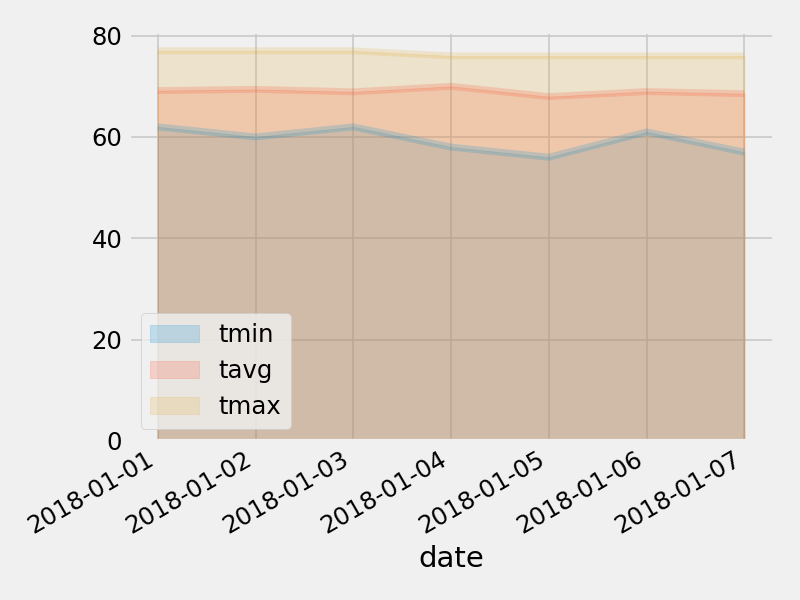

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
